<strong><b><font size="5">Análise Estatística e Modelagem Preditiva de Séries Temporais - Em Python</font></b></strong>

<strong><b><font size="4">Aplicando Inteligência Artificial para fazer previsões</font></b></strong>

O que acha de trazer Inteligência Artificial para nossa conversa?

De todos os modelos que criamos até aqui no curso, nenhum deles pode ser considerado Inteligência Artificial, mas a partir de agora usaremos Deep Learning, atualmente a principalmente técnica de IA e o estado de arte para a solução de diversos problemas, incluindo previsões de séries temporais. 

**Deep Learning - Modelo LSTM**

Os problemas de previsão de séries temporais são um tipo difícil de problema de modelagem preditiva. As séries temporais adicionam a complexidade de uma dependência de sequência entre as variáveis de entrada.

Um tipo poderoso de rede neural projetada para lidar com a dependência de sequência é chamado de Rede Neural Recorrente. A rede Long Short-Term Memory ou LSTM é um tipo de rede neural recorrente usada em aprendizado profundo que apresenta bons resultados, quando devidamente treinada.

Esta e as próximas aulas consideram que você já tem alguma noção sobre o que é Deep Learning e a definição de Deep Learning.

Esse conhecimento pode ser obtido no material gratuito fornecido pela DSA, o <a href="http://www.deeplearningbook.com.br/">Deep Learning Book</a>. Lá você encontra alguns capítulos inteiros dedicados às LSTMs. Recomendamos a leitura antes de prosseguir nesta aula.

**No Google Colab, altere seu Runtime para executar o treinamento usando GPU**.

Vamos ao trabalho.

In [1]:
import sys
import warnings
import matplotlib.cbook
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

# Imports para manipulação de dados
import numpy as np
import pandas as pd
import itertools
from pandas import Series
from pandas.tseries.offsets import DateOffset

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para modelagem preditiva
import sklearn
from sklearn.preprocessing import MinMaxScaler
import statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
#matplotlib.style.use('ggplot')
#%matplotlib inline

from time import time

In [26]:
# Imports para modelagem preditiva - Tensorflow 1.
#import keras
#from keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
#from keras.layers.core import Dense, Activation
#from keras.layers import LSTM
#from keras.layers import Dropout

In [2]:
# Imports para modelagem preditiva - Tensorflow 2.0
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

matplotlib            3.3.3
statsmodels.api       0.12.1
sklearn               0.24.0
numpy                 1.19.5
pandas                1.1.5
tensorflow            2.0.0
tensorflow_core.keras 2.2.4-tf
statsmodels           0.12.1
seaborn               0.11.1
Data Science Academy


## Definição do Problema de Negócio

Previsão do distanciamento social em Minas Gerais.

## Conjunto de Dados

Usaremos conjuntos de dados que mostram o distanciamento social em Minas Gerais. Os dados tem registros de 15/02/2020 a 29/01/2021.

Será fornecido 1 dataset com 2 colunas, data e distanciamento social.

In [4]:
# Carrega os dados
dataframe = pd.read_csv("./data/AIH.csv")
dataframe['Data'] = pd.to_datetime(dataframe.Data, format = '%d/%m/%Y')
dataframe = dataframe.set_index('Data')

In [5]:
# Dados
dataframe.head()

,QT_INTER
Data,
2020-02-15,31.6
2020-02-16,38.9
2020-02-17,24.0
2020-02-18,26.5
2020-02-19,27.8


In [6]:
# Refinamos os dados para o gráfico da série original
# A variável File_System é nossa variável target 
target = dataframe['QT_INTER']

In [7]:
# Random seed 
np.random.seed(7)

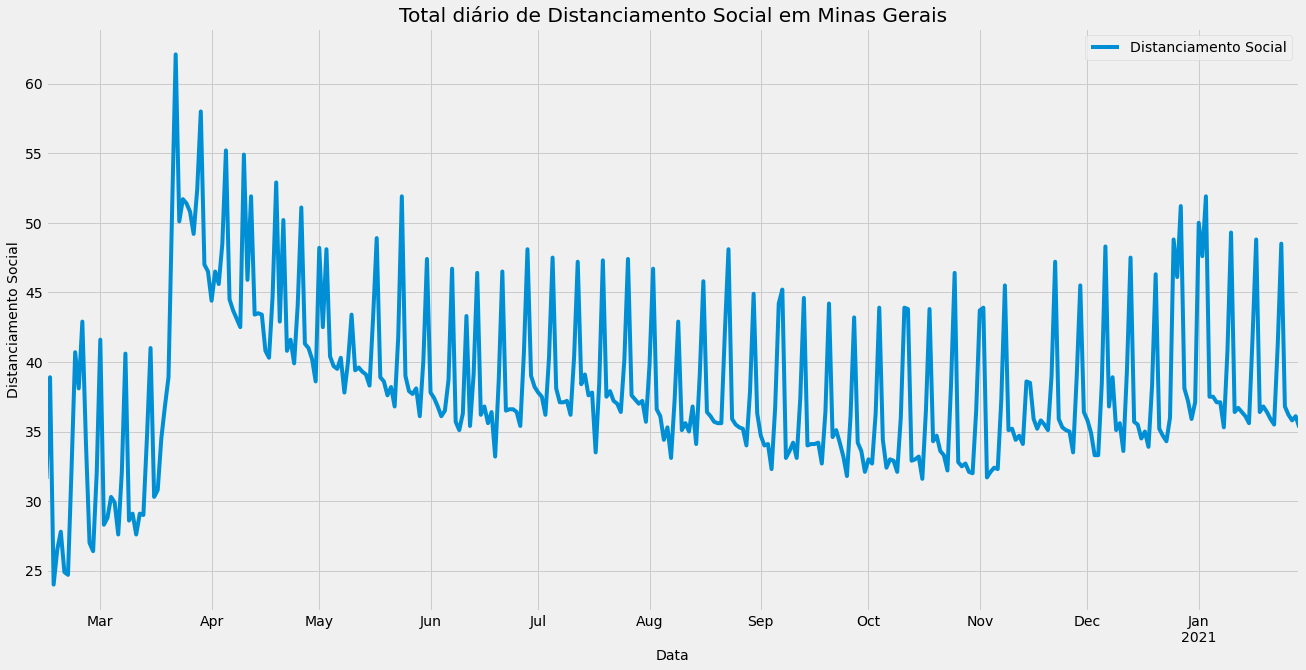

In [8]:
# Plot
target.plot(title = 'Total diário de Distanciamento Social em Minas Gerais', fontsize = 14, label = 'Distanciamento Social') 
plt.xlabel("Data") 
plt.ylabel("Distanciamento Social") 
plt.legend(loc = 'best') 
plt.show()

In [9]:
# Divisão em treino e teste
treino_size = int(len(target) * 0.75)
treino, teste = target[0:treino_size], target[treino_size:]
print(len(treino), len(teste))

262 88


In [10]:
# Ajusta o shape, pois agora não temos um objeto pd.Series, 
# mas sim um array NumPy, que é necessário para treinar o modelo LSTM
trainset = treino.values.reshape(-1,1)
testset = teste.values.reshape(-1,1)

### Função Para o Cálculo da Acurácia

In [11]:
# Função
def performance(y_true, y_pred): 
    mse = ((y_pred - y_true) ** 2).mean()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return( print('MSE das previsões é {}'.format(round(mse, 4))+
                  '\nRMSE das previsões é {}'.format(round(np.sqrt(mse), 4))+
                  '\nMAPE das previsões é {}'.format(round(mape, 4))))

## Modelo LSTM

A rede Long Short-Term Memory, ou LSTM, é uma rede neural recorrente treinada usando Backpropagation Through Time e supera o problema da dissipação do gradiente (isso é explicado no Deep Learning Book).

Como tal, o modelo pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Em vez de neurônios, as redes LSTM possuem blocos de memória conectados através de camadas.

Um bloco possui componentes que o tornam mais inteligente que um neurônio clássico e uma memória para sequências recentes. Um bloco contém portas que gerenciam o estado e a saída do bloco. Um bloco opera sobre uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se são acionadas ou não, condicionando a mudança de estado e a adição de informações que fluem através do bloco.

Existem três tipos de portas dentro de uma unidade:

- Forget Gate: decide condicionalmente quais informações jogar fora do bloco.
- Input Gate: decide condicionalmente quais valores da entrada atualizar o estado da memória.
- Output Gate: decide condicionalmente o que enviar com base na entrada e na memória do bloco.

Cada unidade é como uma máquina de mini estado onde os portões das unidades têm pesos que são aprendidos durante o procedimento de treinamento.

Esse modelo é estudado em detalhes no curso <a href="https://www.datascienceacademy.com.br/course?courseid=deep-learning-ii">Deep Learning II</a>.

### Preparando os Dados Para Treinamento

Como regra geral, sempre que você usa uma rede neural, você deve normalizar ou dimensionar seus dados. Usaremos a classe MinMaxScaler da biblioteca sklearn.preprocessing para dimensionar nossos dados entre 0 e 1. O parâmetro feature_range é usado para especificar o intervalo dos dados dimensionados e se não for especificado o intevalo será entre 0 e 1.

In [12]:
# Cria o scaler para dimensionar nossos dados entre 0 e 1
scaler = MinMaxScaler()

In [13]:
# Treina o scaler nos dados de treino (nunca no dataset completo ou nos dados de teste)
scaler.fit(trainset)

MinMaxScaler()

In [14]:
# Aplica o mesmo scaler aos dados de treino 
# (Não precisamos aplicar aos dados de teste, pois vamos converter a saída das previsões antes de avaliar o modelo)
trainset = scaler.transform(trainset)

Aqui definimos os hiperparâmetros.

In [15]:
# Número de repetições
n_rep = 5

# Número de epochs
num_epochs = 200

# Número de inputs (usaremos 88 séries para prever as 88 séries seguintes)
n_input = 88

# Comprimento das sequências de saída (em número de timesteps)
n_output = 88
# Aqui estamos indicando que nossa série é univariada, logo, apenas 1 recurso
n_features = 1

# Número de amostras de séries temporais em cada lote
size_batch = 10

O TimeseriesGenerator do Keras transforma automaticamente um conjunto de dados univariado de séries temporais em um dataset para problema de aprendizado supervisionado.

https://keras.io/preprocessing/sequence/

In [16]:
# Generator
generator = TimeseriesGenerator(trainset, 
                                trainset, 
                                length = n_output,
                                batch_size = size_batch)

Podemos agora criar o modelo.

Para começar a aplicação de Deep Learning ao nosso problema criaremos um modelo básico de LSTM que chamarei de LSTM Padrão.

Aqui está a principal diferença dos modelos de Deep Learning para outros métodos de previsão de séries temporais. Temos que criar o modelo com cada camada da rede neural.

Como trabalharemos com batches de dados da série que serão passados pela rede várias vezes, vamos criar o modelo e gerar os batches de dados a cada passada de um loop. As camadas de rede nada mais são que operações matemáticas.

Nas próximas aulas ensinarei a você como definir os parâmetros da rede (como número de neurônios e dropout). Por agora, leia os comentários em cada linha de código abaixo.

In [17]:
# Criação e treinamento do modelo LSTM Padrão
start = time()

# Criamos uma matriz preenchida com zeros que receberá o resultado das previsões do nosso modelo
resultado = np.zeros((n_input, n_rep))

# Loop
# Vamos repetir o processo de treinamento por 20 vezes e armazenar todos os resultados, pois assim usaremos
# diferentes amostras. Ao final, tiramos a média para encontrar as previsões.
for i in range(n_rep):
    
    # O primeiro passo é criar o modelo, ou seja, um objeto da classe Sequential() do Keras
    modelo_lstm = Sequential()
    
    # Podemos adicionar agora a primeira camada da rede, ou camada de entrada.
    # Esta é a camada que recebe os dados.
    modelo_lstm.add(LSTM(50, activation = 'relu', input_shape = (n_input, n_features)))
    
    # A camada de Dropout aplica regularização à rede, removendo alguns neurônios e evitando overfitting
    modelo_lstm.add(Dropout(0.10))
    
    # Adicionamos a primeira camada intermediária ou oculta
    modelo_lstm.add(Dense(100, activation = 'relu'))
    
    # Adicionamos a segunda camada intermediária ou oculta
    modelo_lstm.add(Dense(100, activation = 'relu'))
    
    # Adicionamos a camada de saída e tudo que precisamos é de 1 neurônio pois estamos prevendo apenas 1 valor.
    modelo_lstm.add(Dense(1))
    
    # Com as camadas prontas, podemos definir a função de perda, nesse caso usaremos o MSE (Mean Squared Error)
    # E indicamos o algoritmo de otimização (minimização da função de perda), em nosso caso ADAM
    modelo_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    # Aqui fazemos o treinamento gerando batches de dados
    modelo_lstm.fit_generator(generator, epochs = num_epochs)
    
    # Lista para as previsões
    pred_list = []

    # Gera um batch de dados
    batch = trainset[-n_input:].reshape((1, n_input, n_features))

    # Loop para fazer as previsões
    for j in range(n_input):   
        pred_list.append(modelo_lstm.predict(batch)[0]) 
        batch = np.append(batch[:,1:,:], [[pred_list[j]]], axis = 1)

    # Gera o dataframe com as previsões
    df_predict_modelo_lstm = pd.DataFrame(scaler.inverse_transform(pred_list),
                                      index = target[-n_input:].index, columns = ['Prediction'])

    resultado[:,i] = df_predict_modelo_lstm['Prediction']
    
print(resultado)

print ('\nTempo gasto: %s segundos' % str(time() - start))

Epoch 1/200
18/18 [==============================] - 5s 296ms/step - loss: 0.0689
Epoch 2/200
18/18 [==============================] - 5s 276ms/step - loss: 0.0144
Epoch 3/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0131
Epoch 4/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0129
Epoch 5/200
18/18 [==============================] - 5s 281ms/step - loss: 0.0129
Epoch 6/200
18/18 [==============================] - 5s 275ms/step - loss: 0.0129
Epoch 7/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0128
Epoch 8/200
18/18 [==============================] - 5s 283ms/step - loss: 0.0130
Epoch 9/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0133
Epoch 10/200
18/18 [==============================] - 5s 281ms/step - loss: 0.0130
Epoch 11/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0134
Epoch 12/200
18/18 [==============================] - 5s 275ms/step - loss: 0.0132
Epoch 13/200


18/18 [==============================] - 5s 281ms/step - loss: 0.0020
Epoch 197/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0026
Epoch 198/200
18/18 [==============================] - 5s 283ms/step - loss: 0.0027
Epoch 199/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0030
Epoch 200/200
18/18 [==============================] - 5s 282ms/step - loss: 0.0024
Epoch 1/200
18/18 [==============================] - 5s 281ms/step - loss: 0.0561
Epoch 2/200
18/18 [==============================] - 5s 283ms/step - loss: 0.0170
Epoch 3/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0132
Epoch 4/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0131
Epoch 5/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0134
Epoch 6/200
18/18 [==============================] - 5s 283ms/step - loss: 0.0132
Epoch 7/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0127
Epoch 8/200
18/18 [=

Epoch 95/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0092
Epoch 96/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0085
Epoch 97/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0088
Epoch 98/200
18/18 [==============================] - 5s 283ms/step - loss: 0.0095
Epoch 99/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0084
Epoch 100/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0078
Epoch 101/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0094
Epoch 102/200
18/18 [==============================] - 5s 282ms/step - loss: 0.0078
Epoch 103/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0078
Epoch 104/200
18/18 [==============================] - 5s 285ms/step - loss: 0.0080
Epoch 105/200
18/18 [==============================] - 5s 280ms/step - loss: 0.0076
Epoch 106/200
18/18 [==============================] - 5s 284ms/step - loss: 0.00

18/18 [==============================] - 5s 278ms/step - loss: 0.0100
Epoch 91/200
18/18 [==============================] - 5s 280ms/step - loss: 0.0118
Epoch 92/200
18/18 [==============================] - 5s 283ms/step - loss: 0.0109
Epoch 93/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0104
Epoch 94/200
18/18 [==============================] - 5s 286ms/step - loss: 0.0106
Epoch 95/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0106
Epoch 96/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0095
Epoch 97/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0100
Epoch 98/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0097
Epoch 99/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0092
Epoch 100/200
18/18 [==============================] - 5s 287ms/step - loss: 0.0092
Epoch 101/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0089
Epoch 102/200
1

18/18 [==============================] - 5s 286ms/step - loss: 0.0078
Epoch 86/200
18/18 [==============================] - 5s 287ms/step - loss: 0.0092
Epoch 87/200
18/18 [==============================] - 5s 287ms/step - loss: 0.0083
Epoch 88/200
18/18 [==============================] - 5s 287ms/step - loss: 0.0077
Epoch 89/200
18/18 [==============================] - 5s 286ms/step - loss: 0.0077
Epoch 90/200
18/18 [==============================] - 5s 287ms/step - loss: 0.0074
Epoch 91/200
18/18 [==============================] - 5s 288ms/step - loss: 0.0075
Epoch 92/200
18/18 [==============================] - 5s 297ms/step - loss: 0.0073
Epoch 93/200
18/18 [==============================] - 5s 286ms/step - loss: 0.0077
Epoch 94/200
18/18 [==============================] - 5s 285ms/step - loss: 0.0074
Epoch 95/200
18/18 [==============================] - 5s 288ms/step - loss: 0.0068
Epoch 96/200
18/18 [==============================] - 5s 287ms/step - loss: 0.0084
Epoch 97/200
18/1

18/18 [==============================] - 5s 279ms/step - loss: 0.0073
Epoch 81/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0070
Epoch 82/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0067
Epoch 83/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0090
Epoch 84/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0070
Epoch 85/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0067
Epoch 86/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0068
Epoch 87/200
18/18 [==============================] - 5s 295ms/step - loss: 0.0071
Epoch 88/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0078
Epoch 89/200
18/18 [==============================] - 5s 286ms/step - loss: 0.0067
Epoch 90/200
18/18 [==============================] - 5s 280ms/step - loss: 0.0056
Epoch 91/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0074
Epoch 92/200
18/1

Epoch 178/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0031
Epoch 179/200
18/18 [==============================] - 5s 277ms/step - loss: 0.0028
Epoch 180/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0027
Epoch 181/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0038
Epoch 182/200
18/18 [==============================] - 5s 286ms/step - loss: 0.0034
Epoch 183/200
18/18 [==============================] - 5s 281ms/step - loss: 0.0024
Epoch 184/200
18/18 [==============================] - 5s 290ms/step - loss: 0.0027
Epoch 185/200
18/18 [==============================] - 5s 280ms/step - loss: 0.0030
Epoch 186/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0030
Epoch 187/200
18/18 [==============================] - 5s 278ms/step - loss: 0.0029
Epoch 188/200
18/18 [==============================] - 5s 279ms/step - loss: 0.0026
Epoch 189/200
18/18 [==============================] - 5s 278ms/step - loss:

O mais delicado na criação do modelo é definir o input_shape da primeira camada. É isso que o modelo espera como entrada para cada amostra em termos do número de etapas de tempo e do número de recursos.

Estamos trabalhando com uma série univariada, portanto, o número de recursos é um, para uma variável.

O número de etapas de tempo como entrada é o número que escolhemos para prever as sequências de saída. Em nosso exemplo, estamos usando 139 sequências para prever 139 sequências.

Quase sempre temos várias amostras; portanto, o modelo espera que o componente de entrada dos dados de treinamento tenha as dimensões ou a forma:

[samples, timesteps, features]

Em nosso exemplo, nós temos:

- samples = n_rep (5)
- timesteps = n_input (88)
- features = n_features (1)

Agora calculamos o erro modelo.

In [18]:
# Vamos criar uma matriz com as mesmas dimensões da matriz de resultado usada no treinamento
resultado_final = np.zeros((resultado.shape[0],1))

In [19]:
# Loop para gerar as previsões finais
for i in range(resultado.shape[0]):
    resultado_final[i] = np.mean(resultado[i,:])

In [20]:
# Previsões finais
resultado_final

array([[34.71276862],
       [34.63372775],
       [34.38369986],
       [33.56402299],
       [36.20754997],
       [43.09046083],
       [39.49993735],
       [35.47039088],
       [34.84340903],
       [34.52692081],
       [33.94343649],
       [37.3135862 ],
       [43.64004347],
       [38.66893611],
       [35.64175284],
       [35.20037353],
       [34.82917571],
       [34.18449735],
       [38.09817585],
       [44.64676777],
       [38.67732995],
       [35.782342  ],
       [35.54649135],
       [35.1755833 ],
       [34.41999499],
       [38.26044633],
       [44.89770199],
       [38.90553481],
       [35.93379079],
       [35.74247003],
       [35.38228216],
       [34.63331727],
       [38.44333624],
       [45.08401851],
       [38.93325682],
       [36.08453422],
       [35.9028688 ],
       [35.53141482],
       [34.76842985],
       [38.56947066],
       [45.22480207],
       [38.99882808],
       [36.22075183],
       [36.03820143],
       [35.65725062],
       [34

In [21]:
# Ajustamos o shape
resultado_final = resultado_final.reshape((88,))

In [22]:
# Previsões finais
resultado_final

array([34.71276862, 34.63372775, 34.38369986, 33.56402299, 36.20754997,
       43.09046083, 39.49993735, 35.47039088, 34.84340903, 34.52692081,
       33.94343649, 37.3135862 , 43.64004347, 38.66893611, 35.64175284,
       35.20037353, 34.82917571, 34.18449735, 38.09817585, 44.64676777,
       38.67732995, 35.782342  , 35.54649135, 35.1755833 , 34.41999499,
       38.26044633, 44.89770199, 38.90553481, 35.93379079, 35.74247003,
       35.38228216, 34.63331727, 38.44333624, 45.08401851, 38.93325682,
       36.08453422, 35.9028688 , 35.53141482, 34.76842985, 38.56947066,
       45.22480207, 38.99882808, 36.22075183, 36.03820143, 35.65725062,
       34.88423219, 38.66543819, 45.32189757, 39.04895493, 36.33934538,
       36.15568313, 35.76641047, 34.99429713, 38.79629979, 45.46166534,
       39.0756482 , 36.44996999, 36.27443633, 35.87659338, 35.10156631,
       38.93527251, 45.62376596, 39.12909516, 36.56309263, 36.40179661,
       35.99491748, 35.21849186, 39.08101102, 45.78649789, 39.18

In [23]:
# Calculamos e imprimos a performance do modelo
modelo_lstm_performance = performance(testset, resultado_final)
modelo_lstm_performance

MSE das previsões é 35.7213
RMSE das previsões é 5.9767
MAPE das previsões é 10.6874


Nossa rede não apresentou um resultado magnífico, mas não foi ruim. Está no mesmo nível de um modelo SARIMAX 
A diferença é que ainda temos muitas opções de otimização do Modelo LSTM.
Abaixo o plot das previsões.

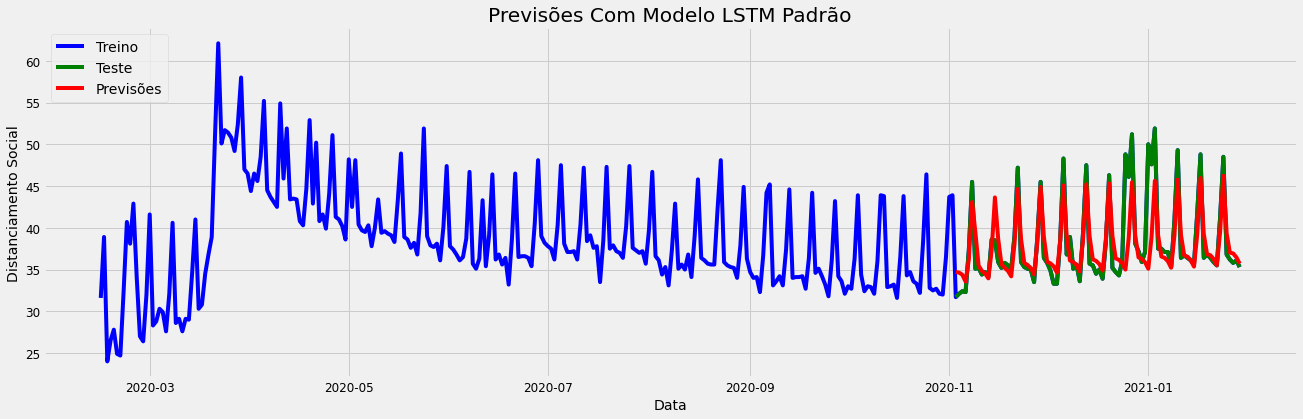

In [24]:
# Plot
plt.figure(figsize = (20, 6))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(target[262:].index, resultado_final, label = 'Previsões', color = 'Red')

plt.title('Previsões Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend(loc = 'upper left')
plt.show()

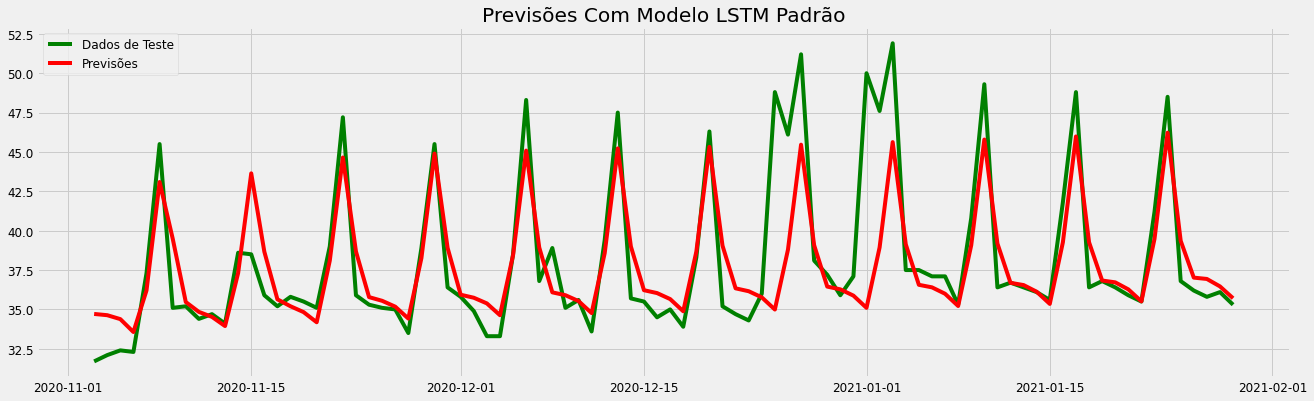

In [25]:
# Plot
plt.figure(figsize = (20, 6))
plt.plot(teste, label = 'Dados de Teste', color = 'green')
plt.plot(target[262:].index, resultado_final, label = 'Previsões', color = 'Red')
plt.title('Previsões Com Modelo LSTM Padrão')
plt.legend(loc = 'upper left', fontsize = 12)
plt.show()

Vamos fazer o Forecasting para 88 dias de horizonte de previsão. A função DateOffset() vai nos ajudar a criar as datas.

Vejamos qual é a última data da nossa série original:

In [26]:
# Última data da série
target.index[-1]

Timestamp('2021-01-29 00:00:00')

In [27]:
# Cria sequência de datas a partir da última data da nossa série original
datas_para_prever_forecasting = [target.index[-1] + DateOffset(days = x) for x in range(0, 89)]

In [28]:
# Visualiza as datas criadas
#datas_para_prever_forecasting

In [29]:
# Nossa série original é um objeto do tipo pd.Series
#type(target)

In [30]:
# Objetos do tipo pd.Series dão mais trabalho para manipular. Vamos converter a série original em dataframe.
df_original = pd.DataFrame(target)

In [31]:
# Visualiza os dados
#df_original.head()

In [32]:
# Vamos agora criar um novo dataframe 
# O índice (data) será a sequência de datas futuras
# O nome da coluna de dados extraímos da série original
# ATENÇÃO: Não estamos extraindo os dados da série original, somente o nome da coluna
data_futuras = pd.DataFrame(index = datas_para_prever_forecasting[1:], columns = df_original.columns)

In [33]:
# Usamos as datas futuras para extrair as previsões do nosso modelo
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index = data_futuras[-n_input:].index, columns = ['Prediction'])

In [34]:
# Concatenamos a série original com os valores de forecasting de 139 semanas além da série
df_forecasting = pd.concat([df_original, df_predict], axis = 1)

In [35]:
# Visualiza o dataframe
df_forecasting

,QT_INTER,Prediction
2020-02-15,31.6,NaN
2020-02-16,38.9,NaN
2020-02-17,24.0,NaN
2020-02-18,26.5,NaN
2020-02-19,27.8,NaN
...,...,...
2021-04-23,NaN,37.026796
2021-04-24,NaN,36.038325
2021-04-25,NaN,36.005145
2021-04-26,NaN,35.464412


### Previsão x Forecasting

Esse dataframe acima é para não restar qualquer dúvida do que estamos fazendo.

Nas **previsões** do modelo, usamos os dados de validação, 24 meses que correspondem aos 24 últimos registros da série original (2017-01-01 a 2017-12-01. Fazemos isso para poder calcular a precisão do modelo, comparando as previsões com os valores reais. Esse é o padrão em Machine Learning.

No **forecasting**, criamos 24 meses após a última data da série original. Obviamente, não temos dados históricos para esses meses e o que queremos é exatamente a previsão de vendas. O forecasting significa usar o modelo treinado e prever valores sobre novas datas.

Bingo!

Vamos colocar o forecasting em um Plot.

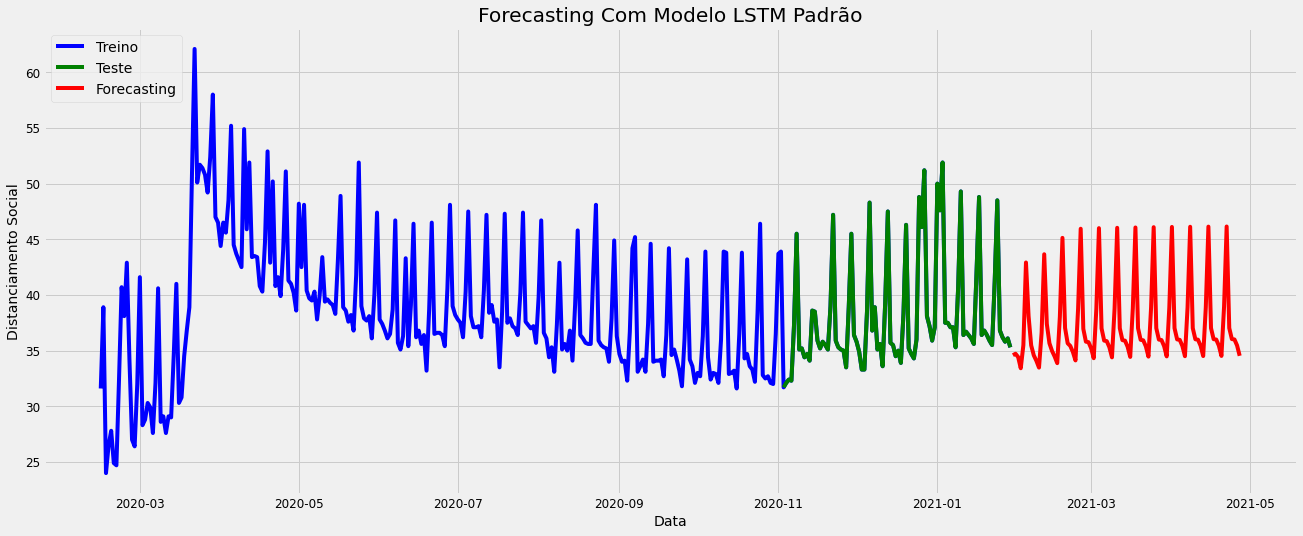

In [36]:
# Plot
plt.figure(figsize = (20, 8))

# Série original
plt.plot(target.index, target.values, label = 'Treino', color = 'Blue')
plt.plot(teste, label = 'Teste', color = 'green')

# Previsões
plt.plot(df_forecasting.index, df_forecasting['Prediction'],
         label = 'Forecasting',  color = 'Red')

plt.title('Forecasting Com Modelo LSTM Padrão')
plt.xlabel('Data')
plt.ylabel('Distanciamento Social')
plt.legend(loc = 'upper left')
plt.show()

E aí está nosso primeiro modelo de Deep Learning para previsão de séries temporais!

Como estamos até agora:
    
- Modelo 15 --> Modelo ARMA (9, 6) - AIC = 1295.100 e RMSE = 3.5966
- Modelo 16 --> Modelo ARIMA Forcast (4, 1, 5) Forecast - AIC = 1385.134 e RMSE = 3.7513
- Modelo 17 --> Modelo SARIMA (2, 1, 1)x(2, 1, 0, 10) - AIC = 1449.398 e RMSE = 6.5842
- Modelo 18 --> Modelo SARIMA (1, 1, 1)x(0, 1, 1, 10) - AIC = 1451.114 e RMSE = 5.0104
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.1241 e RMSE = 3.8363   -   (3 repetições)
- Modelo 22 --> Modelo LSTM Padrão - MAPE = 10.6874 e RMSE = 5.9767   -   (5 repetições)

Nosso modelo de Deep Learning veio para a briga como um candidato de peso. Nas próximas aulas vamos otimizar o modelo e trabalhar com diferentes arquiteturas LSTM.

Todas as aulas deste curso podem ser encontradas na timeline da Comunidade no portal da DSA: www.datascienceacademy.com.br

# Fim